<a href="https://colab.research.google.com/github/josesg998/CursoRL/blob/master/Bandits/epsilon_greedy_vs_greedy_mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Multiarmed Bandits: epsilon-Greedy versus Greedy algorithms**

In this notebook, we use OpenAI Gym to implement epsilon-Greedy and Greedy algorithms

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [ ]:
from gymnasium import spaces
from gymnasium.utils import seeding


class BanditEnv(gym.Env):
    """
    Bandit environment base to allow agents to interact with the class n-armed bandit
    in different variations

    p_dist:
        A list of probabilities of the likelihood that a particular bandit will pay out
    r_dist:
        A list of either rewards (if number) or means and standard deviations (if list)
        of the payout that bandit has
    """
    def __init__(self, p_dist, r_dist):
        if len(p_dist) != len(r_dist):
            raise ValueError("Probability and Reward distribution must be the same length")

        if min(p_dist) < 0 or max(p_dist) > 1:
            raise ValueError("All probabilities must be between 0 and 1")

        #for reward in r_dist:
        #    if isinstance(reward, list) and reward[1] <= 0:
        #        raise ValueError("Standard deviation in rewards must all be greater than 0")

        self.p_dist = p_dist
        self.r_dist = r_dist

        self.n_bandits = len(p_dist)
        self.action_space = spaces.Discrete(self.n_bandits)
        self.observation_space = spaces.Discrete(1)

        self._seed()

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)

        reward = 0
        done = True

        if np.random.uniform() < self.p_dist[action]:
            if not isinstance(self.r_dist[action], list):
                reward = self.r_dist[action]
            else:
                reward = np.random.normal(self.r_dist[action][0], self.r_dist[action][1])

        return 0, reward, done, {}

    def reset(self):
        return 0

    def render(self, mode='human', close=False):
        pass

class BanditTenArmedGaussian(BanditEnv):
    """
    10 armed bandit mentioned on page 30 of Sutton and Barto's
    [Reinforcement Learning: An Introduction](https://www.dropbox.com/s/b3psxv2r0ccmf80/book2015oct.pdf?dl=0)

    Actions always pay out
    Mean of payout is pulled from a normal distribution (0, 1) (called q*(a))
    Actual reward is drawn from a normal distribution (q*(a), 1)
    """
    def __init__(self, bandits=10,sigma:int=1):
        p_dist = np.full(bandits, 1)
        r_dist = []

        for _ in range(bandits):
            r_dist.append([np.random.normal(0, 1), sigma])

        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)


Define the epsilon-Greedy actions (Note: if epsilon=0 it corresponds to the Greedy action)

In [ ]:
def get_action(Q, e):
    if random.random() < e:
        return random.randint(0, 9)
    else:
        return np.argmax(Q)

We want to compare the Average Reward over repeated experiments for different values of epsilon.

We define a function that compute the average of obtained reward over repeated experiments.

In [ ]:
def average(tot_rewards):
    avg = []
    for i in range(len(tot_rewards[0])):
        temp = 0
        for j in range(len(tot_rewards)):
            temp += tot_rewards[j][i]
        temp /= len(tot_rewards)
        avg.append(temp)
    return avg

Main code: define an Environment for 10-armed Bandit whose rewards are normal distributed with standard deviation = 1 and a mean drawn from a normal distribution (0,1). Same as Sutton&Barto book

In [ ]:
def run_experiments(env:BanditTenArmedGaussian,e:int=0,k:int=10,iter:int=1000,repeat:int=2000) -> list:
    env.reset()
    tot_rewards = []
    print(f"Running experiment with e={e}")
    for _ in tqdm(range(repeat)):
        Q = np.zeros(shape=(k))
        N = np.zeros(shape=(k))
        rewards = []
        for i in range(iter):
            action = get_action(Q, e)
            state, reward, done, info = env.step(action)
            rewards.append(reward)
            N[action] += 1
            Q[action] = Q[action] +  1/N[action] * (reward - Q[action])
        env.reset()
        tot_rewards.append(rewards)

    return average(tot_rewards)

In [ ]:
np.random.seed(42)
env_1 = BanditTenArmedGaussian()
e0 = run_experiments(e=0,env=env_1)
e001 = run_experiments(e=0.01,env=env_1)
e01 = run_experiments(e=0.1,env=env_1)
e02 = run_experiments(e=0.2,env=env_1)

Running experiment with e=0


100%|██████████| 2000/2000 [00:42<00:00, 47.45it/s]


Running experiment with e=0.01


100%|██████████| 2000/2000 [00:35<00:00, 55.70it/s]


Running experiment with e=0.1


100%|██████████| 2000/2000 [00:36<00:00, 54.91it/s]


Running experiment with e=0.2


100%|██████████| 2000/2000 [00:35<00:00, 55.66it/s]


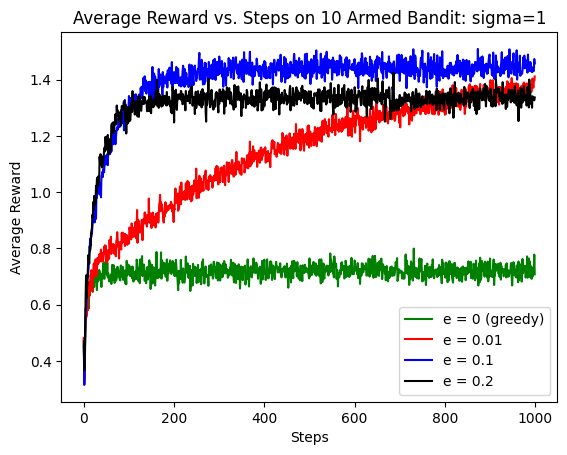

In [ ]:
plt.plot(e0, color='green', label='e = 0 (greedy)')
plt.plot(e001, color='red', label='e = 0.01')
plt.plot(e01, color='blue', label='e = 0.1')
plt.plot(e02, color='black', label='e = 0.2')
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Average Reward vs. Steps on 10 Armed Bandit: sigma=1")
plt.legend()
plt.show()

# ahora con sigma = 0

In [ ]:
np.random.seed(42)
env_sigma_0 = BanditTenArmedGaussian(sigma=0)
e0_sigma_0 = run_experiments(e=0, env=env_sigma_0)
e001_sigma_0 = run_experiments(e=0.01, env=env_sigma_0)
e01_sigma_0 = run_experiments(e=0.1, env=env_sigma_0)

Running experiment with e=0


100%|██████████| 2000/2000 [00:36<00:00, 55.18it/s]


Running experiment with e=0.01


100%|██████████| 2000/2000 [00:37<00:00, 53.82it/s]


Running experiment with e=0.1


100%|██████████| 2000/2000 [00:35<00:00, 55.65it/s]


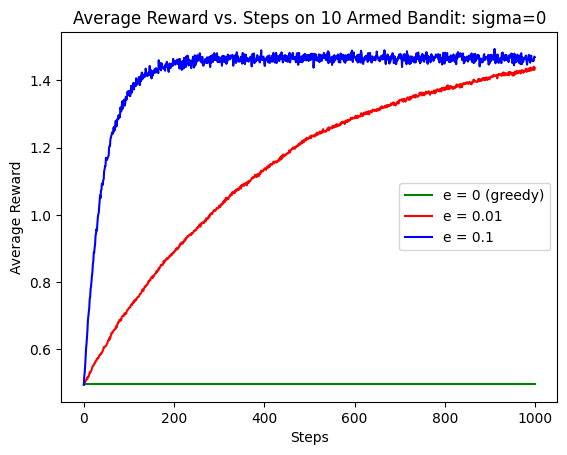

In [ ]:
# plot
plt.plot(e0_sigma_0, color='green', label='e = 0 (greedy)')
plt.plot(e001_sigma_0, color='red', label='e = 0.01')
plt.plot(e01_sigma_0, color='blue', label='e = 0.1')
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Average Reward vs. Steps on 10 Armed Bandit: sigma=0")
plt.legend()
plt.show()

# ahora con sigma = 10


In [ ]:
np.random.seed(42)
env_sigma_10 = BanditTenArmedGaussian(sigma=10)
e0_sigma_10 = run_experiments(e=0, env=env_sigma_10)
e001_sigma_10 = run_experiments(e=0.01, env=env_sigma_10)
e01_sigma_10 = run_experiments(e=0.1, env=env_sigma_10)

Running experiment with e=0


100%|██████████| 2000/2000 [00:36<00:00, 54.07it/s]


Running experiment with e=0.01


100%|██████████| 2000/2000 [00:36<00:00, 55.45it/s]


Running experiment with e=0.1


100%|██████████| 2000/2000 [00:34<00:00, 57.27it/s]


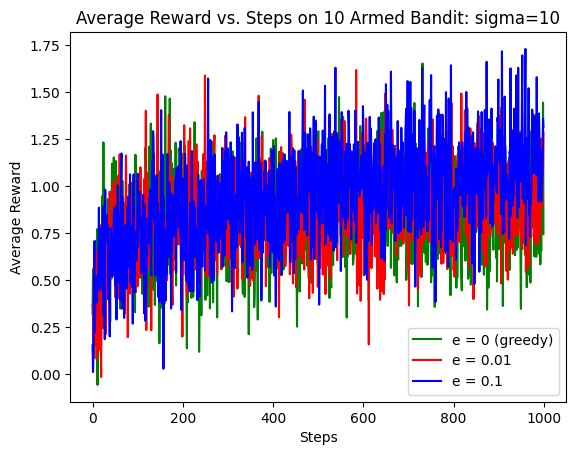

In [ ]:
# plot
plt.plot(e0_sigma_10, color='green', label='e = 0 (greedy)')
plt.plot(e001_sigma_10, color='red', label='e = 0.01')
plt.plot(e01_sigma_10, color='blue', label='e = 0.1')
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Average Reward vs. Steps on 10 Armed Bandit: sigma=10")
plt.legend()
plt.show()